##*DIPENDENZE*

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import cv2 as cv    
import glob
from google.colab.patches import cv2_imshow #se si utilizza colab, usare questo per visualizzare immagini, oppure matplotlib

##*COSTANTI*

In [3]:
#general
PATH = '/content/drive/MyDrive/Computer Vision Algorithms'
PATH_IMGS = PATH + '/*.jpg'
PATH_TO_SAVE = PATH + '/processed_imgs/'

#Yolo things
PATH_YOLO = PATH + '/YoloV3/'
PATH_YOLO_TXT = PATH_YOLO + 'yolov3.txt'
PATH_YOLO_CFG = PATH_YOLO + 'yolov3.cfg'
PATH_YOLO_WEIGHTS = PATH_YOLO + 'yolov3.weights'

#Costanti sulle immagini
IMG_SIZE = (416,416)
SCALE =  0.00392

#costanti operative
MIN_CONFIDENCE = 0.5
THRESHOLD = 0.3

##*FUNZIONI*

In [28]:
'''
RETURN livelli di output di YOLO - 
       frutto la funzione getLayerNames che mi restituisce i nomi dei layer di output, dopodichè
       li prendo con getUnconnectedOutLayers()
'''
def get_output_layers(net):
    layer_names = net.getLayerNames()
     
    output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
    return output_layers

#Raffigurazione dei bounding boxes sull'immagine
def show_detections_results(img, boxes, class_names, confidences):
    
    for box, class_name, conf in zip(boxes, class_names, confidences):
        x, y, w, h = box   #coordinate box corrente
        cv.rectangle(img, (x,y),(x+w,y+h), (0,0,255), 3)   #disegno il bounding box

        label = class_name + " " + str(int(np.round(conf)) * 100)+ "%"

        #cv.rectangle(img, (x-len(label),y-3),(x+w+len(label),y-15), (255,255,255), -1)
        cv.putText(img, label, (x-5, y-3), cv.FONT_HERSHEY_TRIPLEX, 0.5, (255,255,255), 1)
    return img

#prendo il miglior centroide per ogni oggetto
def non_max_suppression(boxes, centroids, confidences, min_confidence, threshold):
    boxesMax = []
    centroidsMax = []
    boxesIds = []
    
    boxesIds = cv.dnn.NMSBoxes(boxes, confidences, min_confidence, nms_threshold=threshold)
    
    for boxId in boxesIds :
      centroidsMax.append(centroids[boxId[0]])
      boxesMax.append(boxes[boxId[0]])
      
    return boxesMax, centroidsMax

##*LETTURA DNN YOLOV3*

In [5]:
# Lettura classi individuabili da yolo
classes = None
with open(PATH_YOLO_TXT, 'r') as f:
    classes = [line.strip() for line in f.readlines()]
 
# Acquisizione del modello già addestrato su imagenet
net = cv.dnn.readNet(PATH_YOLO_CFG,
                      PATH_YOLO_WEIGHTS)

Immagini su cui operare


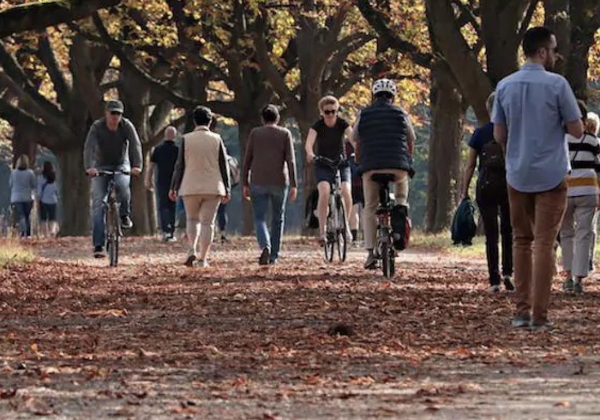

In [6]:
imgs = glob.glob(PATH_IMGS) #suppongo ci siano tante immagini, ma in quest'esempio ne metterò solo una
#imgs = PATH_IMGS
for img in imgs:
  image = cv.imread(img)
  image = cv.resize(image, (600,420))   
  cv2_imshow(image)

##*MAIN*


Persone individuate nell'immagine : 11

Immagine elaborata



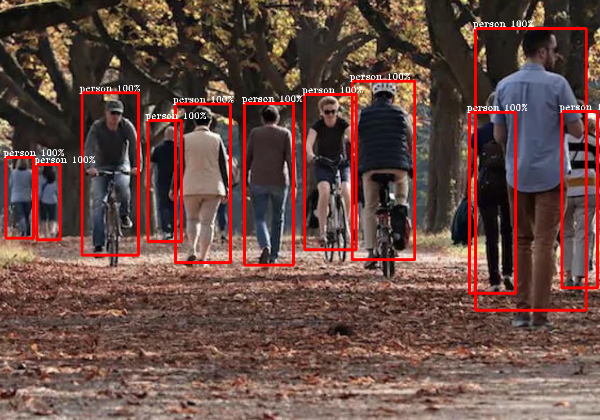

In [29]:

i = 0
for img in imgs:
    
    img = cv.imread(img)
    
    larghezza = img.shape[1]
    altezza = img.shape[0]
    
    #creo il Binary Large Obj (BLOB) dell'immagine
    blob = cv.dnn.blobFromImage(img, scalefactor=SCALE, size=(416,416), 
                                mean=(0,0,0), swapRB=True, crop=False)
    
    #set input per Yolov3
    net.setInput(blob)
    
    #acquisisco l'output - La rete ha tanti layers di output - uno per ogni detection che effettua
    outs = net.forward(get_output_layers(net)) 
    
    '''
    esamino l'output --> un array di array di coordinate.
               La dimensione dell'array è pari al numero di elementi individuati da YOLO.
               Per ogni elemento vi è un array che contiene:
                           i primi 5 punti --> coordinate bounding box
                           i restanti --> probabilità di appartenenza ad una classe
               La probabilità più alta rappresenta la classe dell'oggetto individuato:
                           prendo il suo indice in un array dedicato solo agli scores (probabilità)
                           è lo inserisco nell'array dei nomi degli oggetti individuabili
                           e ottengo l'etichetta dell'oggetto.
                
    '''
    confidences = [] #tutte le probabilità di successo
    boxes = [] #tutti i box degli oggetti individuati (persone)
    centroids = [] #tutti i centroidi degli oggetti individuati
    class_names = [] #etichette di ogni oggetto trovato, in questo caso ci saranno solo etichette di tipo 'person', quindi sarebbe anche inutile utilizzare questa lista
    for out in outs: 
        for detect in out:
            scores = detect[5:]  #creo una lista dedicata agli scores
            class_id = np.argmax(scores) #prendo l'indice dell'oggetto appartente alla classe dell'oggetto
            conf = scores[class_id] #probabilità di successo della previsione fatta
            
            #se la classe è una persona ed ha una discreta probabilità di successo lo considero
            if(classes[class_id] == 'person' and conf>=MIN_CONFIDENCE):
               
               #acquisizione coordinate
               centro_X = int(detect[0]*larghezza) #detect[0] indica la coordinata x del bounding box
               centro_Y = int(detect[1]*altezza) #detect[1] coordinata y
    
               w = int(detect[2]*larghezza) #detect[2] è la larghezza del bounding box
               h = int(detect[3]*altezza) #detect[3] è l'altezza
               #coordinate x y
               x = int(centro_X - w/2)
               y = int(centro_Y - h/2)
               
               class_names.append(classes[class_id])    #potrei dare per scontato di aggiungere una persona, così però basterà cambiare la condizione per individuare qualsiasi oggetto io voglia
               confidences.append(conf.astype(float))
               boxes.append((x, y, w, h))
               centroids.append((centro_X, centro_Y))
            
    #applico la Non Max Suppression --> IOU più basso => miglior bounding box tra i tanti che ne vengono generati
    #questo metodo è utile infatti anche per associare un solo box per ogni oggetto, oltre che il migliore possibile
    boxes, centroids = non_max_suppression(boxes = boxes, 
                                           centroids = centroids,
                                           confidences = confidences, 
                                           min_confidence = MIN_CONFIDENCE, 
                                           threshold = THRESHOLD)
    
    print(f"\nPersone individuate nell'immagine : {len(centroids)}\n")
    #print("Immagine originale")
    #cv2_imshow(img)
    img = show_detections_results(boxes=boxes, class_names=class_names, 
                                  confidences=confidences, 
                                  img = img)
    print("Immagine elaborata\n")
    img = cv.resize(img, (600,420))
    cv2_imshow(img)
    nome_immagine_salvata = 'precessed_img' + str(i) + '.jpg'
   
    
    i+=1
    #cv.imwrite(img, PATH_TO_SAVE + nome_immagine_salvata)